### Đọc dữ liệu đã tiền xử lý


In [1]:
# Load processed dataset if not already in memory
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis
import pandas as pd

processed_path = os.path.join('..', 'data', 'processed', 'netflix_cleaned.csv')
if 'df' not in globals():
    if os.path.exists(processed_path):
        df = pd.read_csv(processed_path, parse_dates=['date_added'], low_memory=False)
        print(f"Loaded processed dataset: {processed_path} — {len(df)} rows")
    else:
        raise FileNotFoundError(f"Processed file not found: {processed_path}")
else:
    print("df already in memory — skipping load.")

Loaded processed dataset: ..\data\processed\netflix_cleaned.csv — 8790 rows


## 4. Câu hỏi nghiên cứu (Research Questions)

Dựa trên các quan sát ban đầu, nhóm tập trung giải quyết 4 câu hỏi trọng tâm, đi từ chiến lược vĩ mô (Quốc gia/Thời gian) đến giải pháp kỹ thuật vi mô (Machine Learning):

### Câu hỏi 1: Chiến lược "Kho lưu trữ" hay "Nhà máy sản xuất"? (Old vs. New Content Strategy)
**Câu hỏi:** "Phân tích khoảng cách giữa năm sản xuất (Release Year) và năm phát hành lên nền tảng (Date Added). Liệu Netflix tại các thị trường trọng điểm đang tập trung thâu tóm bản quyền phim cũ (Legacy Content) hay đẩy mạnh phát hành nội dung mới sản xuất (Originals)?"

**Lý do & Giá trị thực tiễn:**
* **Hiểu về Chuỗi cung ứng nội dung:** Xác định xem Netflix đang đóng vai trò là một kênh truyền hình cáp kiểu mới (chiếu lại phim cũ) hay một Studio sản xuất điện ảnh thực thụ.
* **So sánh thị trường:** Chiến lược này khác nhau thế nào giữa Mỹ (sân nhà) và các thị trường mới nổi? Điều này giúp hiểu định hướng thâm nhập thị trường của Netflix: Dùng phim cũ để lấp đầy kho hay dùng phim mới để thu hút user?

### Câu hỏi 2: Chân dung khán giả mục tiêu (Demographic Targeting)
**Câu hỏi:** "Netflix đang 'già hóa' hay 'trẻ hóa' kho nội dung? Có sự khác biệt nào về cấu trúc phim (Thể loại/Thời lượng) giữa các nhóm nhãn dán độ tuổi (Kids, Teens, Adults) không?"

**Lý do & Giá trị thực tiễn:**
* **Tối ưu hóa phân khúc:** Mỗi độ tuổi có hành vi tiêu thụ nội dung khác nhau. Việc xác định xem Netflix đang ưu tiên nhóm nào (ví dụ: Gen Z hay Millennial) giúp giải thích các quyết định về việc hủy show hoặc gia hạn show.
* **Xu hướng sản xuất:** Phản ánh thực tế xu hướng làm phim hiện đại (ví dụ: phim ngày càng bạo lực hơn hay ngắn hơn?).

### Câu hỏi 3: Bản sắc & Lợi thế cạnh tranh Quốc gia (National Content Specialization)
**Câu hỏi:** "Mỗi cường quốc điện ảnh trên Netflix có đang 'độc quyền' một thế mạnh cụ thể không? (Ví dụ: Nhật Bản thống trị Anime, Hàn Quốc thống trị Drama, Mỹ thống trị Stand-up Comedy?)."

**Lý do & Giá trị thực tiễn:**
* **Xác định DNA Quốc gia:** Không chỉ nhìn vào số lượng phim, mà nhìn vào "Sở trường". Điều này giúp người dùng biết nên tìm đến quốc gia nào khi muốn xem một thể loại cụ thể.
* **Chiến lược Toàn cầu hóa:** Giúp hiểu cách Netflix tận dụng nguồn lực địa phương để phục vụ khán giả toàn cầu (Glocalization).

### Câu hỏi 4 (Machine Learning): Giải pháp Gợi ý thông minh
**Câu hỏi:** "Làm thế nào để xây dựng hệ thống gợi ý (Content-Based Recommendation System) giúp người dùng tìm thấy các bộ phim tương tự dựa trên đặc tính nội dung (Mô tả, Đạo diễn, Diễn viên)?"

**Mục tiêu kỹ thuật:**
* Ứng dụng kỹ thuật **Xử lý ngôn ngữ tự nhiên (NLP)** với **TF-IDF Vectorization** để chuyển đổi văn bản thành dữ liệu số.
* Sử dụng độ đo **Cosine Similarity** để giải quyết bài toán "Information Overload" (Quá tải thông tin) cho người dùng, giúp họ tìm được phim ưng ý ngay cả khi phim đó thiếu dữ liệu đánh giá (Cold Start problem).

### **Câu hỏi 1: Phân tích khoảng cách giữa năm sản xuất (Release Year) và năm phát hành lên nền tảng (Date Added). Liệu Netflix tại các thị trường trọng điểm đang tập trung thâu tóm bản quyền phim cũ (Legacy Content) hay đẩy mạnh phát hành nội dung mới sản xuất (Originals)?**

#### **(A) Tiền xử lý**
- **Data Cleaning:** Đảm bảo cột `date_added` ở định dạng datetime.
- **Feature Engineering:** Tạo biến `lag_time` (Độ trễ) = `year_added` - `release_year`.
- **Outlier Handling:** Loại bỏ các trường hợp `lag_time` < 0 (phim được thêm vào trước khi phát hành - lỗi dữ liệu).
- **Data Transformation:** Tách (explode) cột `country` để phân tích chính xác từng quốc gia.

In [2]:
if 'year_added' not in df.columns:
    df['year_added'] = df['date_added'].dt.year
df['lag_time'] = df['year_added'] - df['release_year']

# Kiểm tra và xử lý ngoại lệ (Lag Time < 0)
invalid_lag = df[df['lag_time'] < 0]
print(f"Số lượng dòng có lag_time < 0 (sẽ bị loại bỏ): {len(invalid_lag)}")
df_clean = df[df['lag_time'] >= 0].copy()

# Data Transformation: Explode Country
df_clean['country_list'] = df_clean['country'].astype(str).str.split(', ')
df_exploded = df_clean.explode('country_list')

# Loại bỏ các dòng country là 'Unknown' hoặc nan để phân tích chính xác hơn
df_exploded = df_exploded[~df_exploded['country_list'].isin(['Unknown', 'nan'])]
print("Dữ liệu sau khi xử lý (5 dòng đầu):")
print(df_exploded[['title', 'country_list', 'release_year', 'year_added', 'lag_time']].head())

Số lượng dòng có lag_time < 0 (sẽ bị loại bỏ): 14
Dữ liệu sau khi xử lý (5 dòng đầu):
                  title   country_list  release_year  year_added  lag_time
0  Dick Johnson Is Dead  United States          2020        2021         1
1         Blood & Water   South Africa          2021        2021         0
4          Kota Factory          India          2021        2021         0
7               Sankofa  United States          1993        2021        28
7               Sankofa          Ghana          1993        2021        28


#### **(B) Phương pháp phân tích**
**Mục tiêu:** Xác định chiến lược nội dung (tập trung vào phim mới hay kho phim cũ) của Netflix tại các thị trường lớn.

**Phương pháp sử dụng:**
1. **Selection:** Chọn Top 5 quốc gia có lượng nội dung lớn nhất trên Netflix.
2. **Aggregation:** Tính trung bình `lag_time` theo từng năm (`year_added`) cho mỗi quốc gia.
3. **Visualization:** Sử dụng biểu đồ đường (Multi-line Chart) để theo dõi xu hướng thay đổi của độ trễ qua thời gian.

**Expected outputs:**
- Biểu đồ xu hướng Lag Time của 5 quốc gia hàng đầu từ năm 2016 đến nay.

Top 5 quốc gia có nhiều nội dung nhất: ['United States', 'India', 'United Kingdom', 'Canada', 'France']


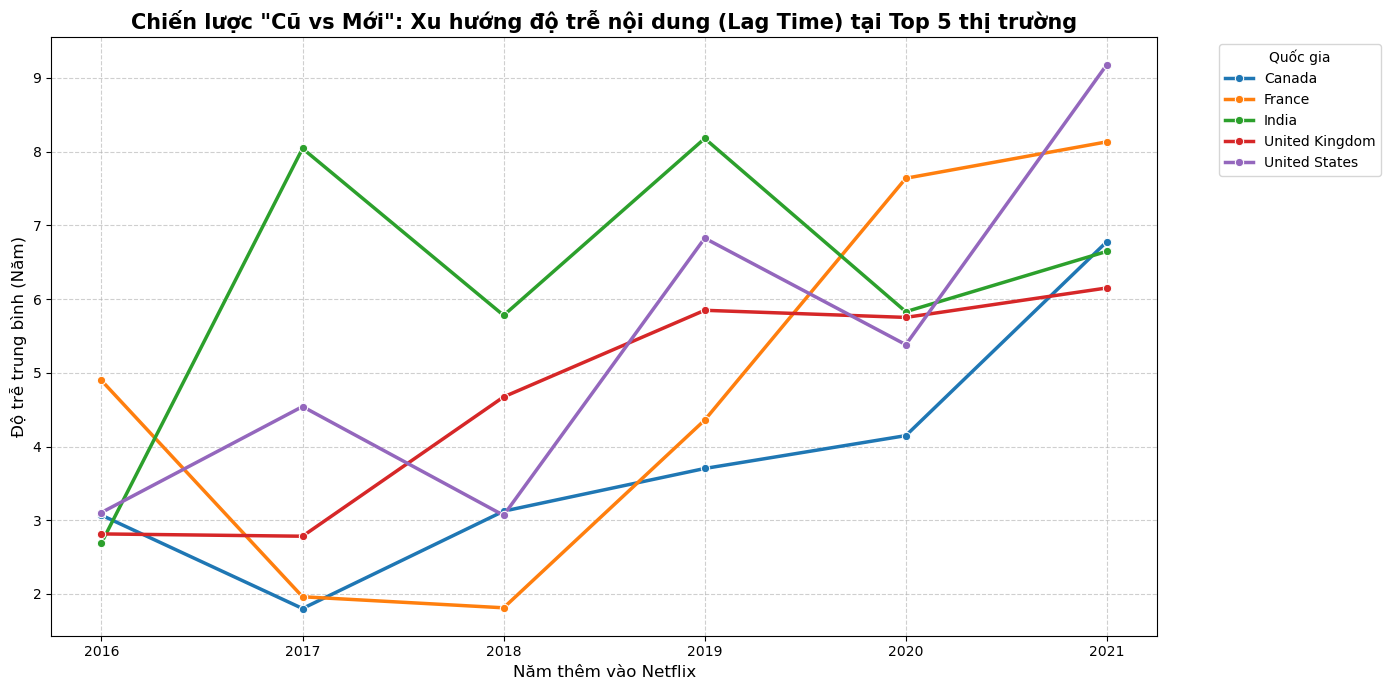

In [3]:
top_5_countries = df_exploded['country_list'].value_counts().head(5).index.tolist()
print(f"Top 5 quốc gia có nhiều nội dung nhất: {top_5_countries}")
df_top5 = df_exploded[df_exploded['country_list'].isin(top_5_countries)]	
lag_time_trend = df_top5.groupby(['year_added', 'country_list'])['lag_time'].mean().reset_index()
lag_time_trend = lag_time_trend[lag_time_trend['year_added'] >= 2016]

plt.figure(figsize=(14, 7))
sns.lineplot(data=lag_time_trend, x='year_added', y='lag_time', hue='country_list', 
             marker='o', linewidth=2.5, palette='tab10')

plt.title('Chiến lược "Cũ vs Mới": Xu hướng độ trễ nội dung (Lag Time) tại Top 5 thị trường', fontsize=15, fontweight='bold')
plt.xlabel('Năm thêm vào Netflix', fontsize=12)
plt.ylabel('Độ trễ trung bình (Năm)', fontsize=12)
plt.legend(title='Quốc gia', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

#### **(C) Kết quả & Giải thích**


1. Xu hướng chung: Sự "già hóa" nội dung trong giai đoạn 2019-2021

- Trái ngược với giả thuyết rằng Netflix ngày càng tập trung vào nội dung mới sản xuất (Originals) để giảm độ trễ, biểu đồ cho thấy độ trễ trung bình (Lag Time) đang tăng ở hầu hết các thị trường trọng điểm, đặc biệt là từ năm 2019 đến 2021.
Điều này cho thấy Netflix đang tích cực bổ sung các kho phim cũ vào thư viện thay vì chỉ tập trung vào phim mới phát hành.

2. Phân tích chi tiết các thị trường:

- Mỹ (United States - Đường tím): Đây là thị trường có biến động lớn nhất. Sau khi duy trì độ trễ thấp (~3 năm) vào 2016, độ trễ đã tăng vọt lên mức kỷ lục >9 năm vào năm 2021. Điều này chứng tỏ trong năm 2021, Netflix Mỹ đã nhập về một lượng lớn phim kinh điển hoặc phim cũ để làm dày thư viện.
- Ấn Độ (India - Đường xanh lá): Có chiến lược rất khác biệt và biến động mạnh. Giai đoạn 2017 và 2019 là lúc Netflix thâm nhập thị trường bằng cách thâu tóm các kho phim Bollywood kinh điển (Lag time đạt đỉnh >8 năm). Tuy nhiên, xen kẽ đó là những năm họ tập trung vào nội dung mới hơn.
- Pháp (France - Đường cam): Có sự đảo chiều ngoạn mục. Từ vị thế là thị trường được ưu tiên nội dung mới nhất (2017-2018 với Lag time ~2 năm), Pháp đã chuyển sang nhập khẩu phim cũ mạnh mẽ vào 2020-2021 (tăng vọt lên ~8 năm).
Canada & Anh (Đường xanh dương & đỏ): Có xu hướng tăng trưởng độ trễ ổn định và đồng pha với nhau (từ mức ~2-3 năm lên ~6-7 năm), cho thấy chiến lược tại các nước phương Tây (ngoài Mỹ) khá tương đồng.

3. Nguyên nhân chiến lược (Tại sao Lag Time lại tăng?):

- Có thể là do tác động của COVID-19: Sự gia tăng độ trễ đồng loạt từ năm 2020 đến 2021 phản ánh rõ nét tác động của đại dịch. Khi hoạt động sản xuất phim mới bị đình trệ do giãn cách xã hội, Netflix buộc phải mua bản quyền các phim cũ để lấp đầy khoảng trống nội dung và giữ chân người dùng.


### **Câu hỏi 2: Netflix đang 'già hóa' hay 'trẻ hóa' kho nội dung? Có sự khác biệt nào về cấu trúc phim (Thể loại/Thời lượng) giữa các nhóm nhãn dán độ tuổi (Kids, Teens, Adults) không?**

#### **(A) Tiền xử lý**

**Mục tiêu:** Chuyển đổi dữ liệu Rating thô thành các nhóm đối tượng khán giả có ý nghĩa để phân tích xu hướng nội dung.

**Các bước thực hiện:**
1.  **Mapping (Ánh xạ):** Tạo từ điển để gom các nhãn rating chi tiết vào 4 nhóm chính theo tiêu chuẩn MPAA(https://www.metrotheatres.com/mpaa-ratings/):
    *   **Kids (Trẻ em):** TV-Y, TV-Y7, G, TV-G, PG, TV-Y7-FV - Nội dung an toàn cho trẻ dưới 13 tuổi.
    *   **Teens (Thanh thiếu niên):** PG-13, TV-14, TV-PG - Nội dung cho lứa tuổi 13-17.
    *   **Adults (Người lớn):** TV-MA, R, NC-17 - Nội dung cho người từ 18 tuổi trở lên.
    *   **Unrated (Không phân loại):** NR, UR - Chưa được đánh giá chính thức.
2.  **Data Validation:** Đảm bảo cột `duration` và `year_added` đã được xử lý ở phần trước.

In [4]:
rating_map = {
    'TV-Y': 'Kids', 'TV-Y7': 'Kids', 'G': 'Kids', 'TV-G': 'Kids', 
    'PG': 'Kids', 'TV-Y7-FV': 'Kids',
    
    'PG-13': 'Teens', 'TV-14': 'Teens', 'TV-PG': 'Teens',
    'TV-MA': 'Adults', 'R': 'Adults', 'NC-17': 'Adults',
    
    'NR': 'Unrated', 'UR': 'Unrated'
}


df['target_audience'] = df['rating'].map(rating_map).fillna('Unrated')
audience_dist = df['target_audience'].value_counts()
print(audience_dist)
print(f"\nTỷ lệ phần trăm:")
print((audience_dist / len(df) * 100).round(2))

target_audience
Adults     4007
Teens      3508
Kids       1193
Unrated      82
Name: count, dtype: int64

Tỷ lệ phần trăm:
target_audience
Adults     45.59
Teens      39.91
Kids       13.57
Unrated     0.93
Name: count, dtype: float64


#### **(B) Phân tích**

**Phương pháp thực hiện:**

**1. Time-Series Analysis (Phân tích xu hướng theo thời gian):**
*   Tạo **Pivot Table** để tính tỷ trọng (%) của từng nhóm tuổi theo năm `year_added`.
*   **Trực quan hóa:** Sử dụng **Stacked Area Chart** để quan sát sự thay đổi "miếng bánh" thị phần qua các năm.
*   **Mục tiêu:** Trả lời Netflix đang "già hóa" (tăng nội dung Adults) hay "trẻ hóa" (tăng nội dung Kids/Teens).

**2. Multivariate Analysis (Phân tích cấu trúc nội dung):**
*   **Yếu tố 1 - Duration (Thời lượng):** So sánh phân phối thời lượng phim (chỉ Movies) giữa 3 nhóm bằng **Boxplot**.
*   **Yếu tố 2 - Genre Diversity (Đa dạng thể loại):** Đếm số lượng thể loại duy nhất mà mỗi nhóm khán giả tiếp cận.

**Công cụ:** Pandas (pivot_table, groupby), Matplotlib, Seaborn.

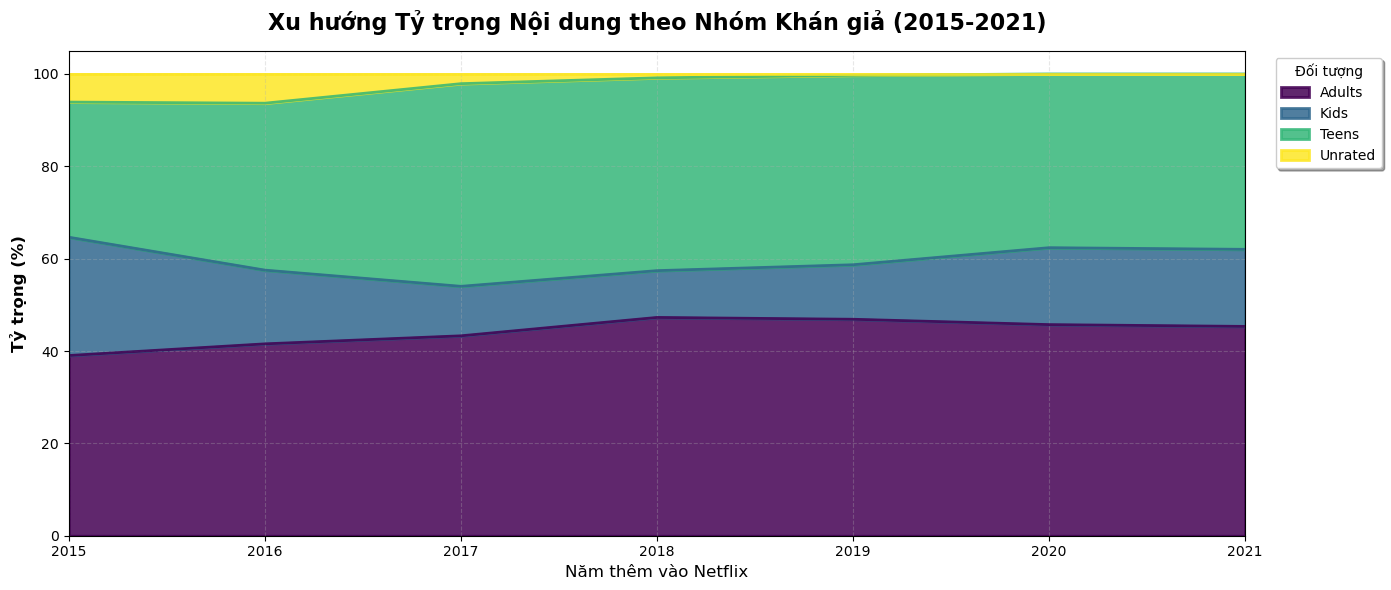

In [5]:
df_trend = df[df['year_added'] >= 2015].copy()
age_year_pivot = pd.crosstab(df_trend['year_added'], df_trend['target_audience'], 
                              normalize='index') * 100

fig, ax = plt.subplots(figsize=(14, 6))

age_year_pivot.plot(kind='area', stacked=True, ax=ax, 
                     colormap='viridis', alpha=0.85, linewidth=2)
ax.set_title('Xu hướng Tỷ trọng Nội dung theo Nhóm Khán giả (2015-2021)', 
             fontsize=16, fontweight='bold', pad=15)
ax.set_ylabel('Tỷ trọng (%)', fontsize=12, fontweight='bold')
ax.set_xlabel('Năm thêm vào Netflix', fontsize=12)
ax.legend(title='Đối tượng', bbox_to_anchor=(1.02, 1), loc='upper left', 
          frameon=True, shadow=True)
ax.margins(0, 0)		
ax.grid(alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

C:\Users\ACER\AppData\Local\Temp\ipykernel_20156\3213198687.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bp = sns.boxplot(data=df_movies, x='target_audience', y='duration',


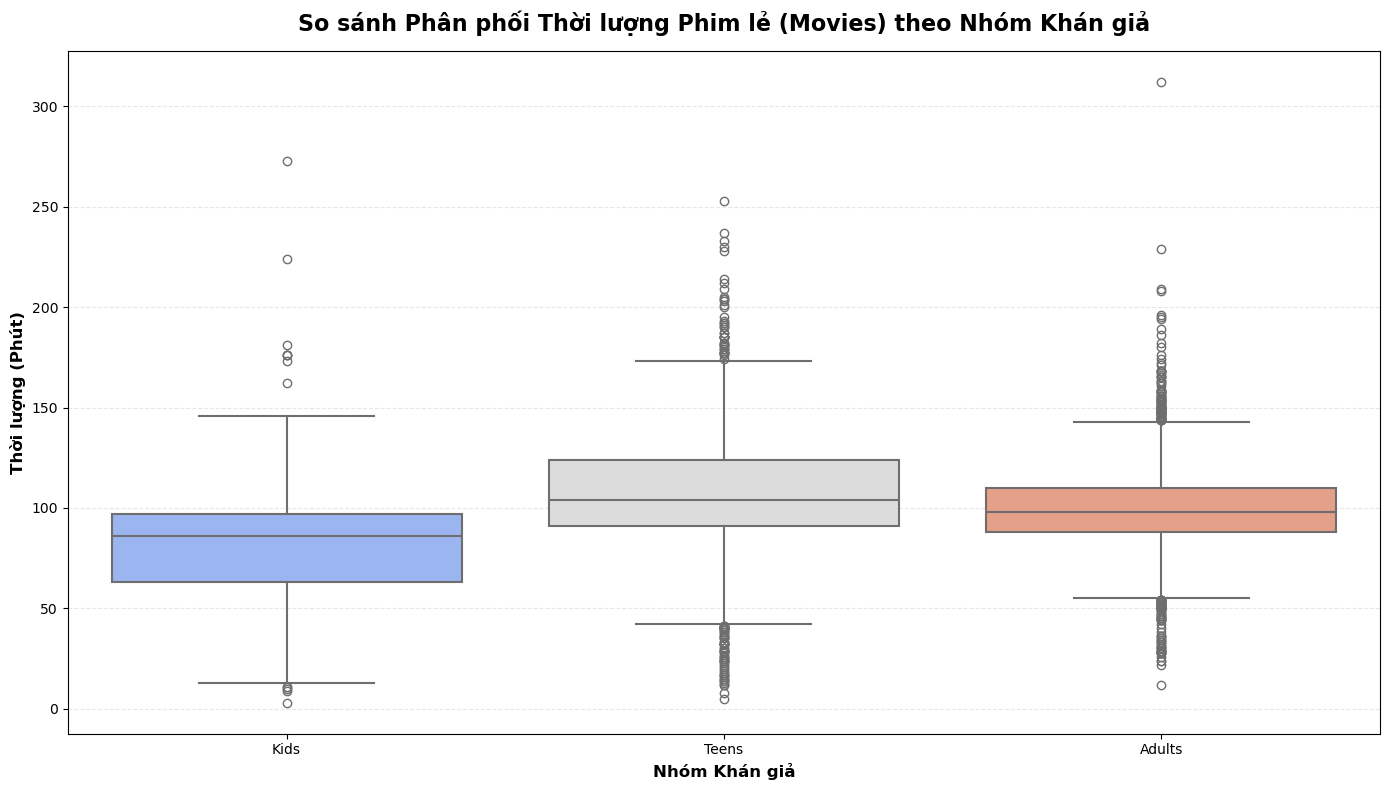

In [6]:
df_movies = df[(df['type'] == 'Movie') & (df['target_audience'] != 'Unrated')].copy()

fig, ax = plt.subplots(figsize=(14, 8))
bp = sns.boxplot(data=df_movies, x='target_audience', y='duration', 
                 order=['Kids', 'Teens', 'Adults'], palette='coolwarm', ax=ax,
                 linewidth=1.5)

ax.set_title('So sánh Phân phối Thời lượng Phim lẻ (Movies) theo Nhóm Khán giả', 
             fontsize=16, fontweight='bold', pad=15)
ax.set_ylabel('Thời lượng (Phút)', fontsize=12, fontweight='bold')
ax.set_xlabel('Nhóm Khán giả', fontsize=12, fontweight='bold')
ax.grid(axis='y', alpha=0.3, linestyle='--')
audiences = ['Kids', 'Teens', 'Adults']
for i, audience in enumerate(audiences):
	data = df_movies[df_movies['target_audience'] == audience]['duration']
	q1 = data.quantile(0.25)
	median = data.median()
	q3 = data.quantile(0.75)
	iqr = q3 - q1
	lower_whisker = q1 - 1.5 * iqr
	upper_whisker = q3 + 1.5 * iqr
	outliers = data[(data < lower_whisker) | (data > upper_whisker)]
	n_outliers = len(outliers)
plt.tight_layout()
plt.show()


In [7]:
for audience in audiences:
	data = df_movies[df_movies['target_audience'] == audience]['duration']
	q1 = data.quantile(0.25)
	median = data.median()
	q3 = data.quantile(0.75)
	iqr = q3 - q1
	lower_whisker = q1 - 1.5 * iqr
	upper_whisker = q3 + 1.5 * iqr
	outliers = data[(data < lower_whisker) | (data > upper_whisker)]
	n_outliers = len(outliers)
	print(f"\n{audience}:")
	print(f"  • Trung vị (Median): {median:.0f} phút")
	print(f"  • Tứ phân vị (Q1-Q3): {q1:.0f} - {q3:.0f} phút")
	print(f"  • Khoảng tứ phân vị (IQR): {iqr:.0f} phút")
	print(f"  • Ngưỡng Outlier: < {lower_whisker:.0f} hoặc > {upper_whisker:.0f} phút")
	print(f"  • Số lượng Outliers: {n_outliers} phim")


Kids:
  • Trung vị (Median): 86 phút
  • Tứ phân vị (Q1-Q3): 63 - 97 phút
  • Khoảng tứ phân vị (IQR): 34 phút
  • Ngưỡng Outlier: < 12 hoặc > 148 phút
  • Số lượng Outliers: 13 phim

Teens:
  • Trung vị (Median): 104 phút
  • Tứ phân vị (Q1-Q3): 91 - 124 phút
  • Khoảng tứ phân vị (IQR): 33 phút
  • Ngưỡng Outlier: < 42 hoặc > 174 phút
  • Số lượng Outliers: 111 phim

Adults:
  • Trung vị (Median): 98 phút
  • Tứ phân vị (Q1-Q3): 88 - 110 phút
  • Khoảng tứ phân vị (IQR): 22 phút
  • Ngưỡng Outlier: < 55 hoặc > 143 phút
  • Số lượng Outliers: 172 phim


#### **(C) Kết quả & Diễn giải**

**1. Netflix đang "Già hóa" hay "Trẻ hóa"? → Câu trả lời: ĐANG "GIÀ HÓA"**

*   **Bằng chứng từ Stacked Area Chart:**
    *   Vùng màu đại diện cho **Adults (Người lớn)** mở rộng đáng kể từ 2015 đến 2021, từ ~40% lên gần **50%** tổng nội dung mới.
    *   Ngược lại, tỷ trọng của **Kids (Trẻ em)** thu hẹp lại hoặc đi ngang.
    *   Còn tỉ lệ tuổi teen có su hướng mở rộng ở giai đoạn đầu và có thu hẹp nhẹ và gần như chững lại vào những năm 2020 và 2021
*   **Ý nghĩa chiến lược:**
    *   Netflix đã chuyển dịch rõ ràng từ một nền tảng "gia đình toàn diện" (Family-friendly) sang một nền tảng giải trí "cao cấp" (Premium Adult Content).
    *   Các series hit như Squid Game, The Witcher, Stranger Things (Season 3+), Bridgerton đều mang nhãn TV-MA hoặc R - đây là chiến lược có chủ đích để thu hút nhóm khách hàng 18-49 tuổi (nhóm chi trả cao nhất).

**2. Sự khác biệt về Cấu trúc Phim (Duration Analysis):**

**Kids (Trẻ em):**
- Thời lượng phim ngắn nhất với trung vị khoảng 63 - 97 phút (median line nằm thấp).
- Phân phối hộp khá rộng (hộp boxplot rộng) - cho thấy độ đa dạng cực lớn.
- Lý do: Khả năng tập trung của trẻ em vào mình hình điện tử khá cao, các nhà sản xuất không quá khắt khe với thời lượng phim, chỉ cần đảm bảo nó không quá dài để không gây ra các vấn đề về mắt.
- Outliers: Có một vài bộ phim dài bất thường (>200 phút) - có thể là các bộ phim hoạt hình dài tập hoặc compilation movies.

**Teens(Thanh thiếu niên)**
- Thời lượng ở mức trung bình, trung vị khoảng  91 - 124 phút.
- Phân phối rộng tương đương Kids  - thể hiện sự đa dạng trong phân khúc này, thời lượng của độ tuổi này cũng nâng lên đáng kể để có thể truyền tải nhiều nội dung film hơn.

**Adult(Người lớn)**
- Thời lượng dài nhất, trung vị khoảng 88 - 110 phút.
- Phân phối hẹp (hộp hẹp) nhưng bù lại đây là nhóm có tỉ lệ oulier cao nhất (172) 
- Outliers cực nhiều: Hàng chục điểm nằm trên 200 phút 
- Ý nghĩa: Người lớn có patience và nhu cầu cao hơn với storytelling sâu sắc, do đó Netflix tự do thử nghiệm với độ dài phim, không bị ràng buộc bởi "chuẩn mực rạp chiếu" (90-120 phút).

### **Câu 3: Mỗi cường quốc điện ảnh trên Netflix có đang 'độc quyền' một thế mạnh cụ thể không? (Ví dụ: Nhật Bản thống trị Anime, Hàn Quốc thống trị Drama, Mỹ thống trị Stand-up Comedy?).**
#### **(A) Tiền xử lý**
Bước này rất quan trọng vì dữ liệu Netflix có dạng "lồng nhau" (nested).
*   Một phim có thể thuộc nhiều quốc gia (VD: "US, UK").
*   Một phim có thể thuộc nhiều thể loại (VD: "Action, Comedy").
*   Cần tách (explode) cả hai cột này để phân tích chính xác tần suất xuất hiện.

In [8]:
df_clean = df.dropna(subset=['country', 'listed_in']).copy()
df_clean['country'] = df_clean['country'].str.split(', ')
df_clean['listed_in'] = df_clean['listed_in'].str.split(', ')
df_exploded = df_clean.explode('country')
df_double_exploded = df_exploded.explode('listed_in')
df_double_exploded['country'] = df_double_exploded['country'].str.strip()
df_double_exploded['listed_in'] = df_double_exploded['listed_in'].str.strip()
print(f"Số dòng dữ liệu sau khi Double Explode: {len(df_double_exploded)}")
df_double_exploded[['title', 'country', 'listed_in']].head(5)

Số dòng dữ liệu sau khi Double Explode: 23725


,title,country,listed_in
0,Dick Johnson Is Dead,United States,Documentaries
1,Blood & Water,South Africa,International TV Shows
1,Blood & Water,South Africa,TV Dramas
1,Blood & Water,South Africa,TV Mysteries
2,Ganglands,Unknown,Crime TV Shows


#### **(B) Phân tích**

*   **Matrix Creation:** Tạo bảng chéo giữa Quốc gia và Thể loại.
*   **Normalization:** Tính chỉ số RCA (Revealed Comparative Advantage).
    *   `RCA > 1`: Quốc gia có thế mạnh về thể loại này.
    *   `RCA < 1`: Quốc gia ít tập trung vào thể loại này.
*   **Visualization:** Sử dụng Clustered Heatmap để gom nhóm các quốc gia tương đồng.

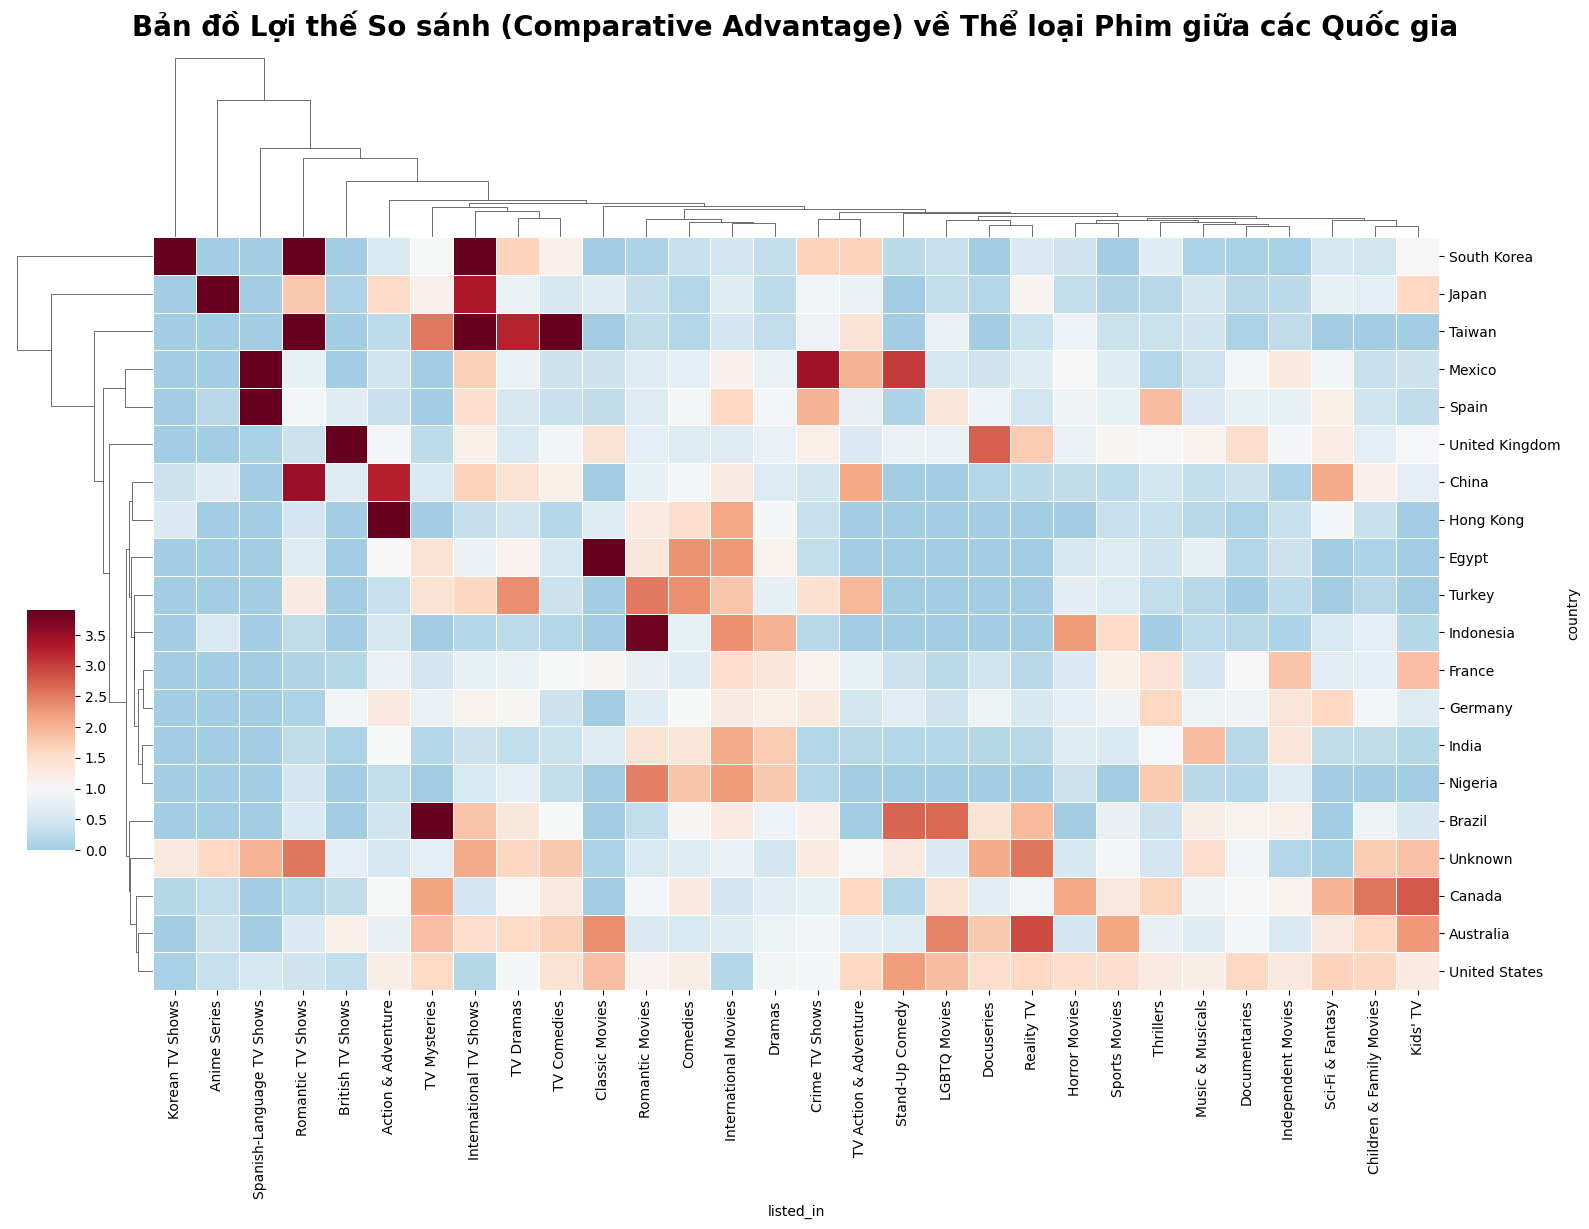

In [9]:
top_countries = df_double_exploded['country'].value_counts().head(20).index
df_top20 = df_double_exploded[df_double_exploded['country'].isin(top_countries)]
country_genre_pct = pd.crosstab(df_top20['country'], df_top20['listed_in'], normalize='index')
global_genre_counts = df_double_exploded['listed_in'].value_counts(normalize=True)

# Tính Lợi thế so sánh (Comparative Advantage) = % Quốc gia / % Toàn cầu
advantage_matrix = country_genre_pct.div(global_genre_counts, axis=1)
advantage_matrix = advantage_matrix.fillna(0) # Xử lý các thể loại không có ở quốc gia đó

# Chỉ lấy các thể loại phổ biến (xuất hiện trong top 30 thể loại) để biểu đồ không quá rối
top_genres = df_double_exploded['listed_in'].value_counts().head(30).index
valid_top_genres = [g for g in top_genres if g in advantage_matrix.columns]
matrix_viz = advantage_matrix[valid_top_genres]
g = sns.clustermap(matrix_viz, 
                   cmap='RdBu_r', 
                   center=1, 
                   robust=True, 
                   figsize=(16, 12),
                   linewidths=.5, 
                   dendrogram_ratio=(.1, .2),
                   cbar_pos=(.02, .32, .03, .2))

g.fig.suptitle('Bản đồ Lợi thế So sánh (Comparative Advantage) về Thể loại Phim giữa các Quốc gia', 
               fontsize=20, fontweight='bold', y=1.02)
plt.show()


C:\Users\ACER\AppData\Local\Temp\ipykernel_20156\4046156393.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_strengths.values, y=top_strengths.index, ax=axes[i], palette='viridis')
C:\Users\ACER\AppData\Local\Temp\ipykernel_20156\4046156393.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_strengths.values, y=top_strengths.index, ax=axes[i], palette='viridis')
C:\Users\ACER\AppData\Local\Temp\ipykernel_20156\4046156393.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_strengths.values, y=top_strengths.index, ax=axes[

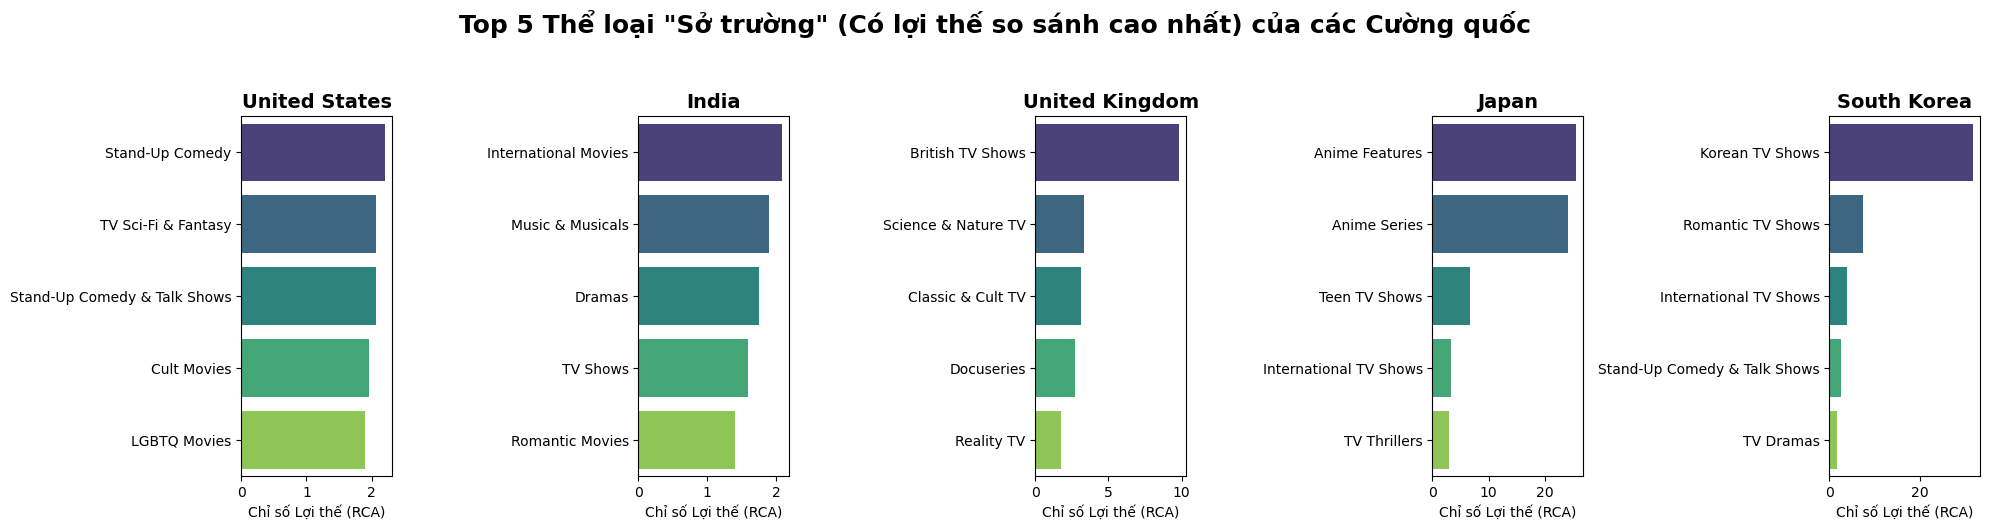

In [10]:
target_countries = ['United States', 'India', 'United Kingdom', 'Japan', 'South Korea']
fig, axes = plt.subplots(1, 5, figsize=(20, 5), sharey=False) 

for i, country in enumerate(target_countries):
    if country in advantage_matrix.index:
        top_strengths = advantage_matrix.loc[country].sort_values(ascending=False).head(5)
        sns.barplot(x=top_strengths.values, y=top_strengths.index, ax=axes[i], palette='viridis')
        axes[i].set_title(country, fontsize=14, fontweight='bold')
        axes[i].set_xlabel('Chỉ số Lợi thế (RCA)')
        axes[i].set_ylabel('')

plt.suptitle('Top 5 Thể loại "Sở trường" (Có lợi thế so sánh cao nhất) của các Cường quốc', 
             fontsize=18, fontweight='bold', y=1.05)
plt.tight_layout()
plt.show()

#### **(C) Kết quả & Diễn giải (Results & Interpretation)**

**1. Nhận diện "Thị trường ngách" (Niche Markets):**
*   **Nhật Bản & Hàn Quốc:**
    *   **Nhật Bản:** Có chỉ số lợi thế cực cao ở **Anime Features** và **Anime Searis**. Đây có thể xem là "vũ khí" xuất khẩu văn hóa chủ lực. Đúng với dự đoán ban đầu.
    *   **Hàn Quốc:** Tập trung mạnh vào **Korea TV Shows** (K-Drama) và **Romantic TV Shows**.
*   **Ấn Độ:**
    *   Thế mạnh tuyệt đối thường nằm ở **International Movies**, **Music & Musicals** và **Dramas**. Bollywood sản xuất lượng phim khổng lồ nhưng ít tập trung vào các thể loại như Sci-Fi hay Horror so với Mỹ.
*   **Mỹ (United States):**
    *   Là thị trường "đa dạng" nhất nhưng vẫn có thế mạnh nổi trội ở **TV Sci & Fantasy**, **Stand-Up Comedy** . Mỹ là cái nôi của hài độc thoại và phim khoa học viễn tưởng, và Fantasty. Phần mỹ có thể thấy chỉ số lợi thế đều ở top 5 thể loại film đa dạng nhất.

**2. Các cụm quốc gia tiêu biểu:**
* **Cụm Đông Á (South Korea, Japan, Taiwan):** * Nhóm này tách biệt rõ rệt với lợi thế tuyệt đối ở các thể loại đặc thù. 
    * **South Korea** dẫn đầu về *Korean TV Shows*, trong khi **Japan** thống trị mảng *Anime Series*.
    * Cả cụm đều có chỉ số rất cao ở *International TV Shows*, cho thấy định hướng xuất khẩu văn hóa mạnh mẽ.

* **Cụm các nước nói tiếng Anh (United States, Canada, Australia):**
    * Các quốc gia này hội tụ ở nhóm dưới của biểu đồ.
    * Lợi thế tập trung vào các thể loại giải trí thực tế và giáo dục như: *Documentaries*, *Reality TV*, và *Kids' TV*.
    * **United Kingdom** mặc dù nằm gần nhóm này nhưng có nét riêng biệt rất đậm ở *British TV Shows*.

* **Cụm ngôn ngữ Tây Ban Nha (Spain, Mexico):**
    * Được xếp gần nhau nhờ sự tập trung vào *Spanish-Language TV Shows*. 
    * Ngoài ra, nhóm này cũng có xu hướng mạnh về các thể loại kịch tính và tội phạm (*Crime TV Shows*).

**3. Lợi thế so sánh theo thể loại (Key Insights):**
* **Điện ảnh khu vực (International Movies):** Các quốc gia có nền công nghiệp điện ảnh nội địa phát triển mạnh như **India** (Bollywood), **Nigeria** (Nollywood) và **Egypt** có màu sắc đậm rõ rệt ở ô *International Movies*.
* **Hành động & Võ thuật:** **Hong Kong** và **China** thể hiện sự vượt trội về lợi thế so sánh trong thể loại *Action & Adventure* so với phần còn lại của thế giới.
* **Sự khác biệt của Brazil:** Quốc gia này tạo ra một "điểm cháy" (nâu đậm) rất đặc trưng ở thể loại *TV Mysteries*, một phân khúc không phải là thế mạnh của các nước láng giềng trong khu vực Mỹ La-tinh trên bản đồ này.
